## Setup

In [15]:
from src.phrase_analysis import process_directory, plot_phrase_frequency_over_time_all, plot_length_distribution, analyze_files_phrase_occurrences, get_recent_contexts_all, get_per_appearance_frequency, calculate_poisson_predictions, calculate_negative_binomial_predictions, format_prediction_table
from src.regex_pattern_generator import generate_regex_patterns
from datetime import datetime

In [16]:
PHRASES = ['Woke',
 'Unity',
 'Truce',
 'Trump',
 'Soldier',
 'Rise',
 'Putin',
 'Peace Deal / Peace Treaty',
 'Nobel',
 'Mission',
 'Missile',
 'Mineral',
 'Future',
 'Fund / Funding',
 'Eliminate',
 'Drone',
 'Donbas',
 'Distract / Distraction',
 'Crimea',
 'Ceasefire']

SEARCH_PHRASES = generate_regex_patterns(PHRASES)

from pprint import pprint
pprint(SEARCH_PHRASES)

{'Ceasefire': "\\b(?:\\w+-)*(?:ceasefire|ceasefires|ceasefire's|ceasefires')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Crimea': "\\b(?:\\w+-)*(?:crimea|crimeas|crimea's|crimeas')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Distract / Distraction': "\\b(?:\\w+-)*(?:(?:distract|distracts|distract's|distracts'|distraction|distractions|distraction's|distractions'))(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Donbas': "\\b(?:\\w+-)*(?:donbas|donba|donbas's|donbass'|donba')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Drone': "\\b(?:\\w+-)*(?:drone|drones|drone's|drones')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Eliminate': "\\b(?:\\w+-)*(?:eliminate|eliminates|eliminate's|eliminates')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Fund / Funding': "\\b(?:\\w+-)*(?:(?:fund|funds|fund's|funds'|funding|fundings|funding's|fundings'))(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Future': "\\b(?:\\w+-)*(?:future|futures|future's|futures')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Mineral': "\\b(?:\\w+-)*(?:mineral|minerals|mineral's|minerals')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Missile': "\\

In [39]:
# Process transcripts
df = process_directory('../data-zelensky/', SEARCH_PHRASES)
df = df.sort_values('date')

df_recent = df[df['date'] > '2025-08-24']

# Print dataset statistics
print("Dataset Statistics:")

print(f"\nAll Transcripts:")
print(f"Total: {len(df)}")
print(f"Total recent: {len(df_recent)}")

print("\nWord Count Statistics:")

print(f"\nAll Transcripts:")
print(f"Average length: {df['text_length'].mean():.0f} words") 
print(f"Average recent length: {df_recent['text_length'].mean():.0f} words")


print("\nDate Ranges:")

print(f"\nAll Transcripts:")
print(f"Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"Date range recent: {df_recent['date'].min().strftime('%Y-%m-%d')} to {df_recent['date'].max().strftime('%Y-%m-%d')}")

Categories found in directory:
- 
Dataset Statistics:

All Transcripts:
Total: 341
Total recent: 32

Word Count Statistics:

All Transcripts:
Average length: 702 words
Average recent length: 831 words

Date Ranges:

All Transcripts:
Date range: 2024-09-24 to 2025-09-24
Date range recent: 2025-08-25 to 2025-09-24


## Phrase Frequency Over Time

Speeches dropped off dramatically between election day and inauguration day. Non-speech transcripts mostly don't go back as far in time (need to scrape more data)

/Users/jstenger/Documents/repos/kalshi-research/src/phrase_analysis.py:211: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(np.log10(0.1), np.log10(ymax + 0.1))



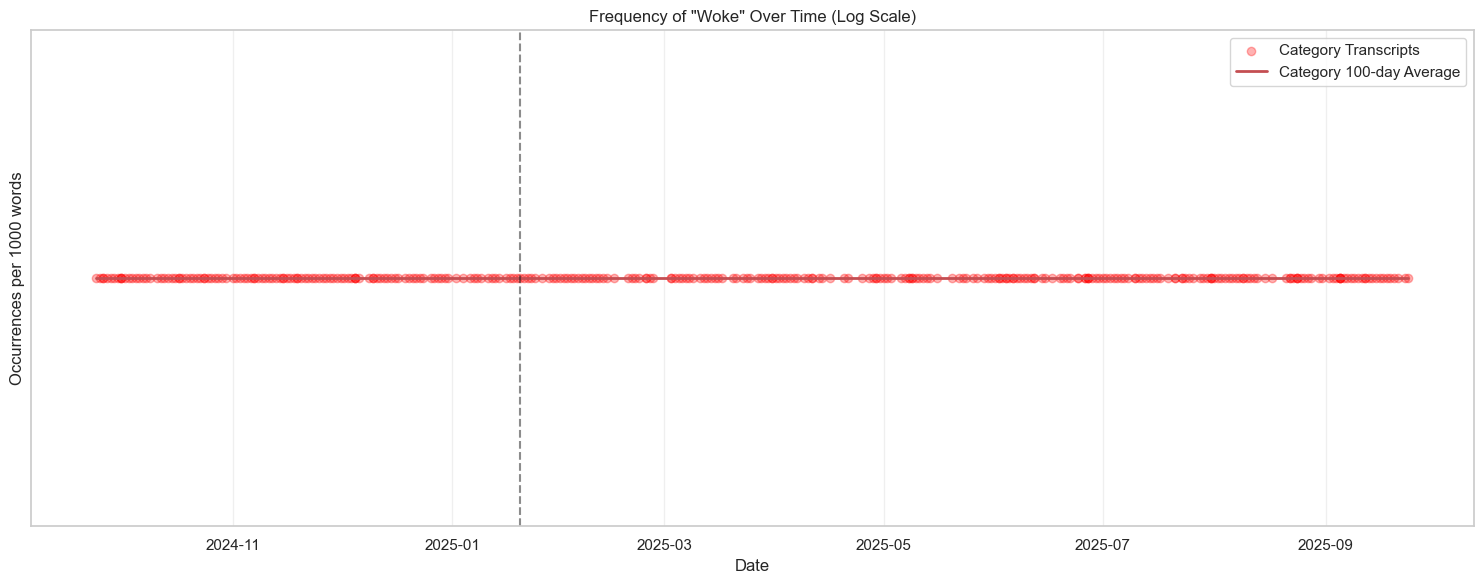


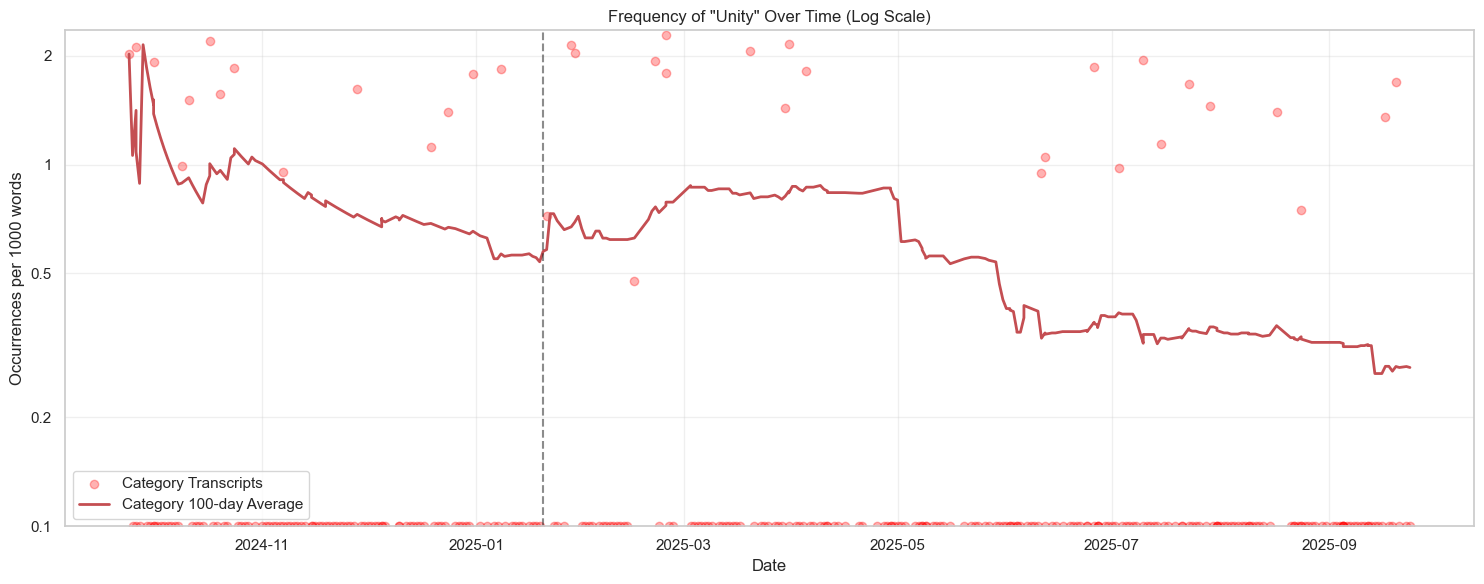


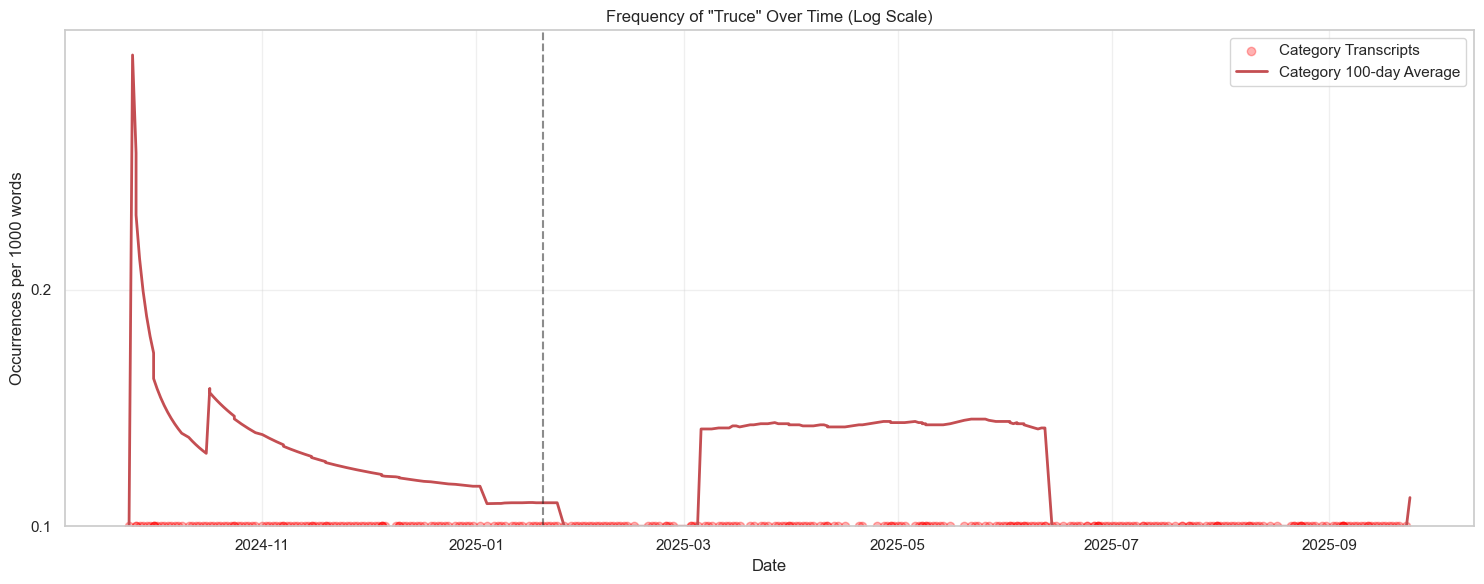


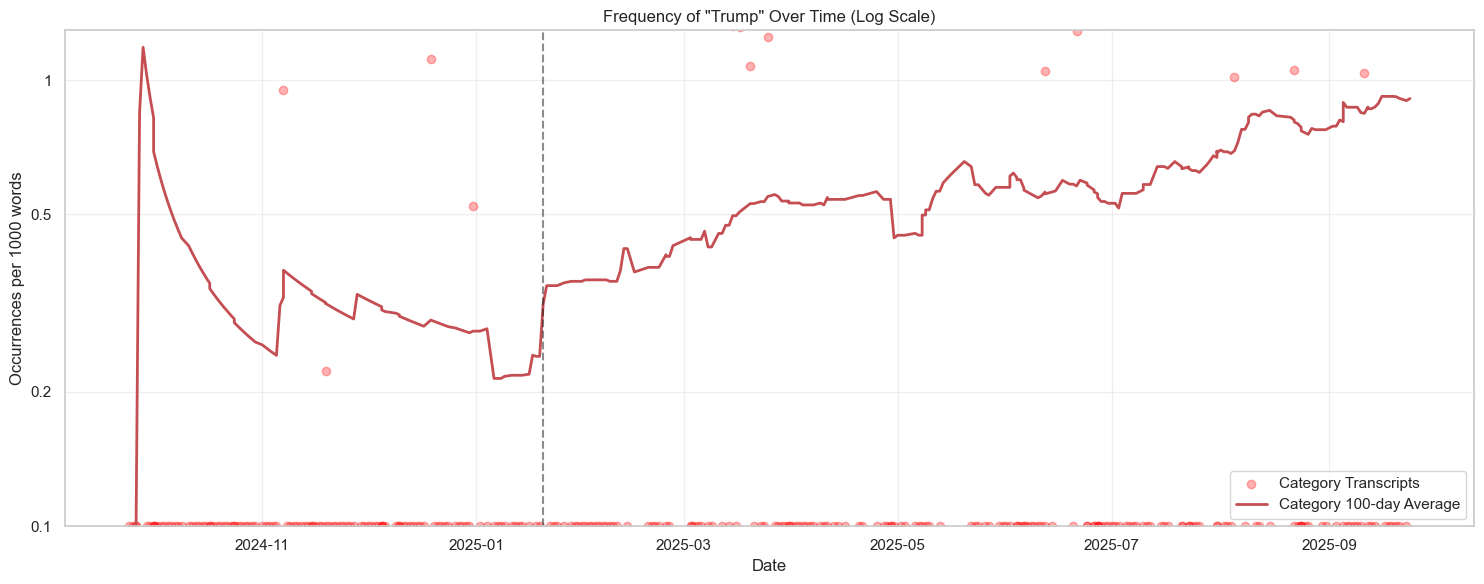


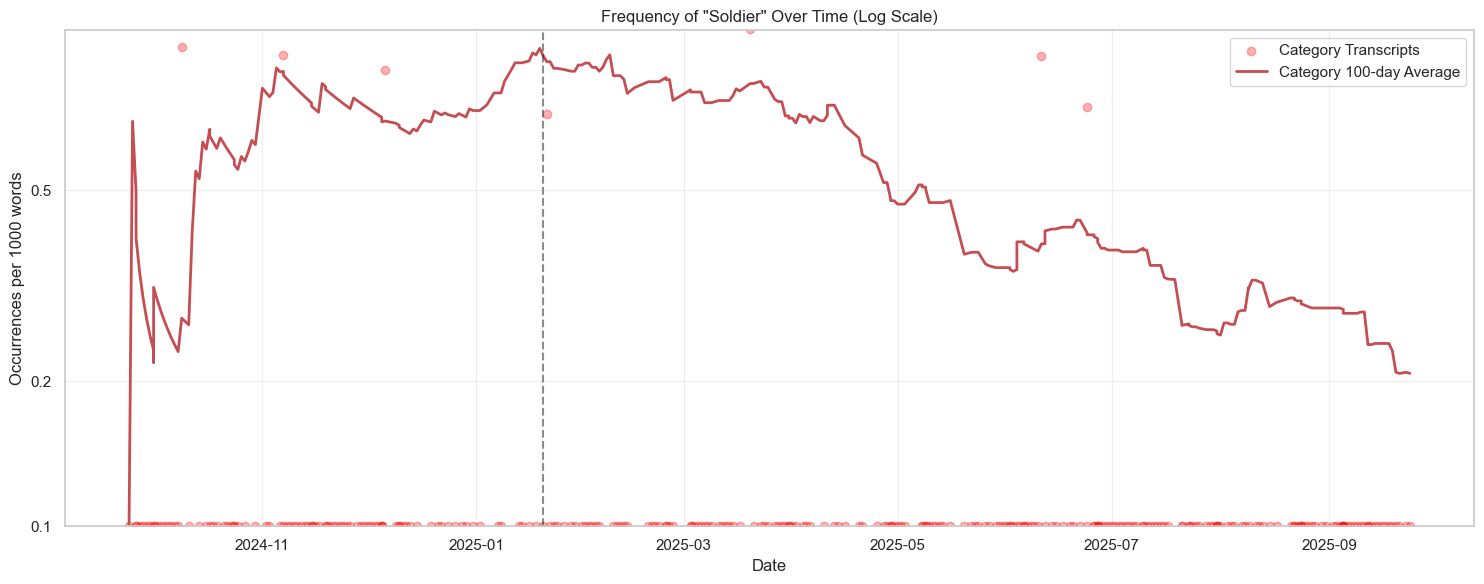


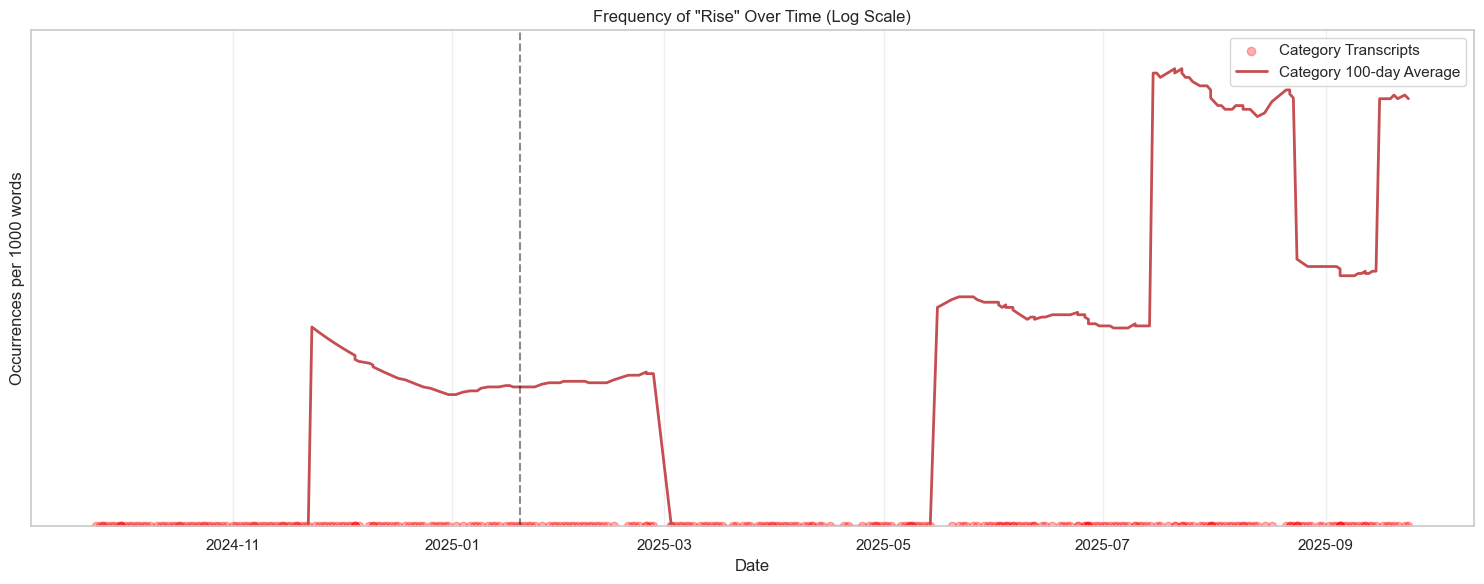


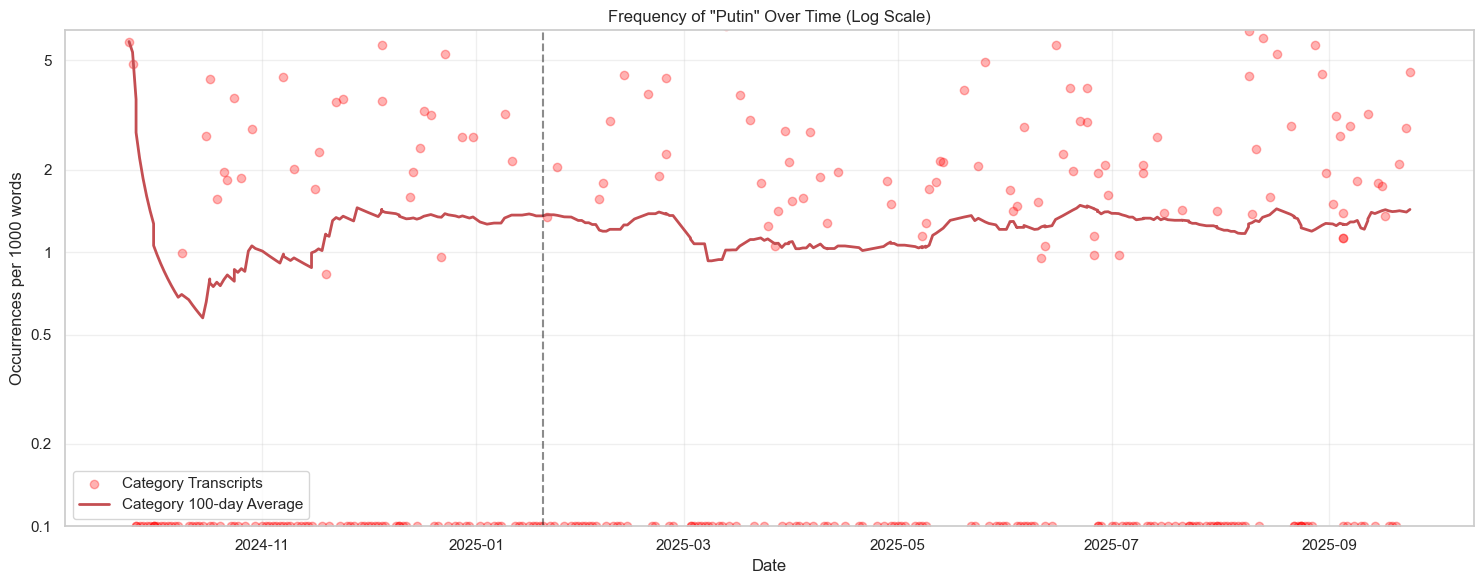


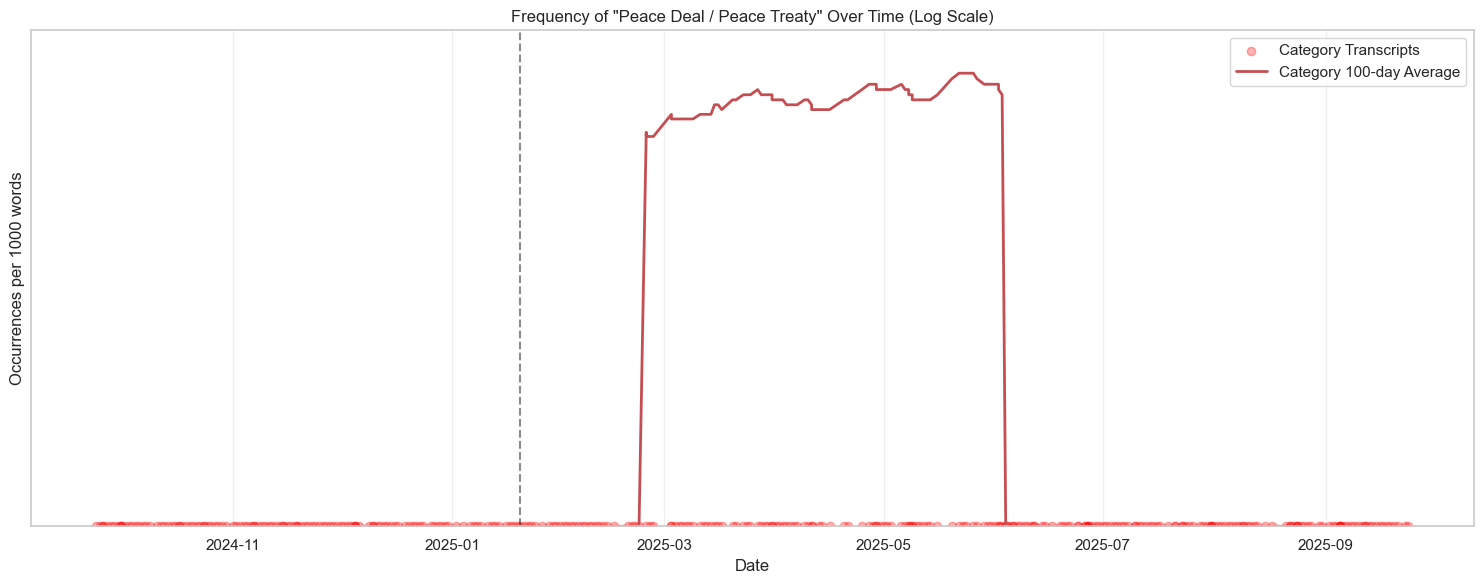


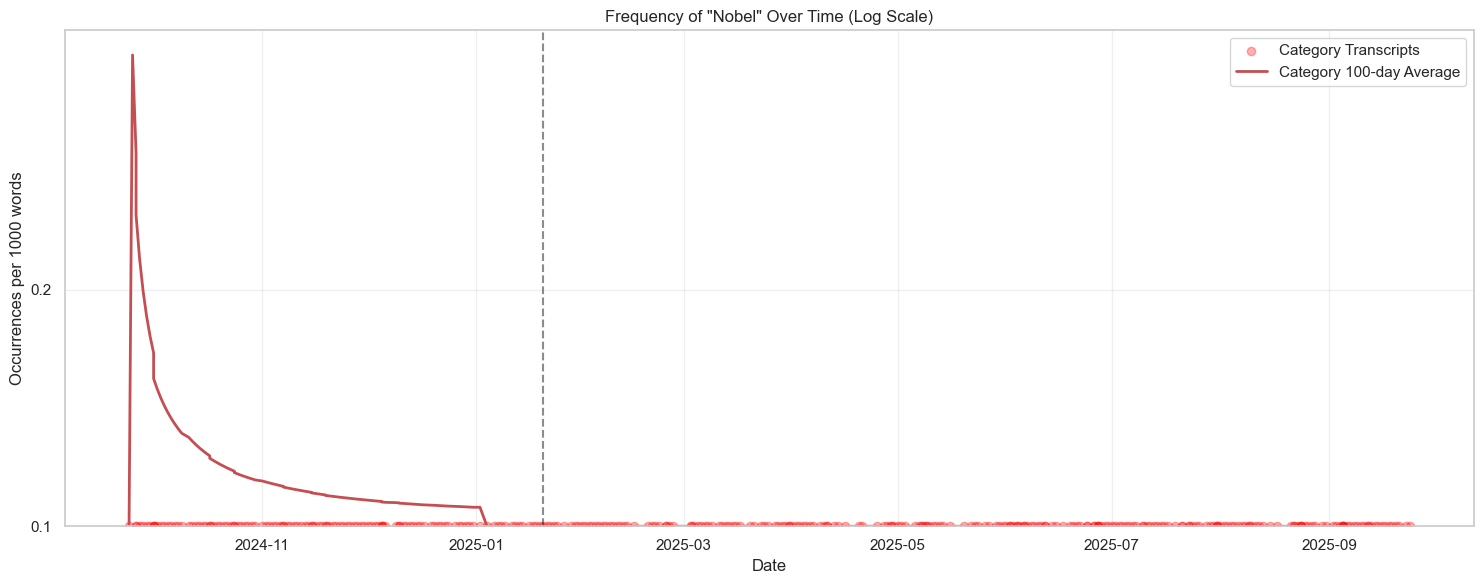


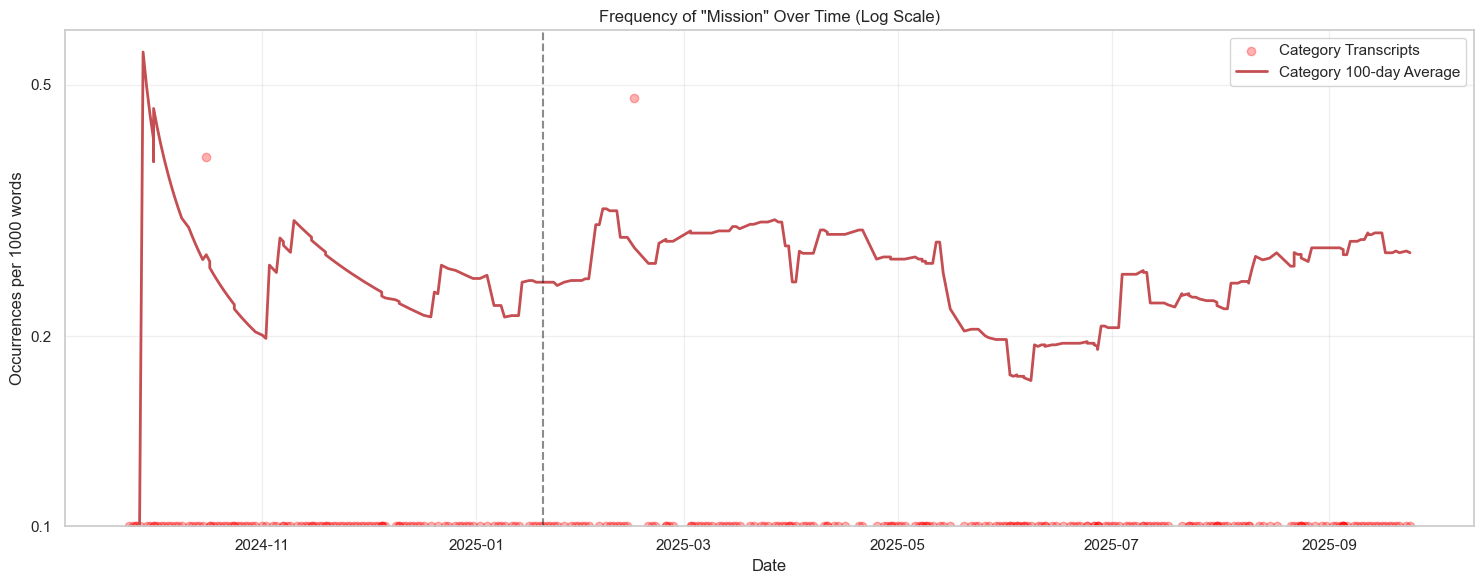


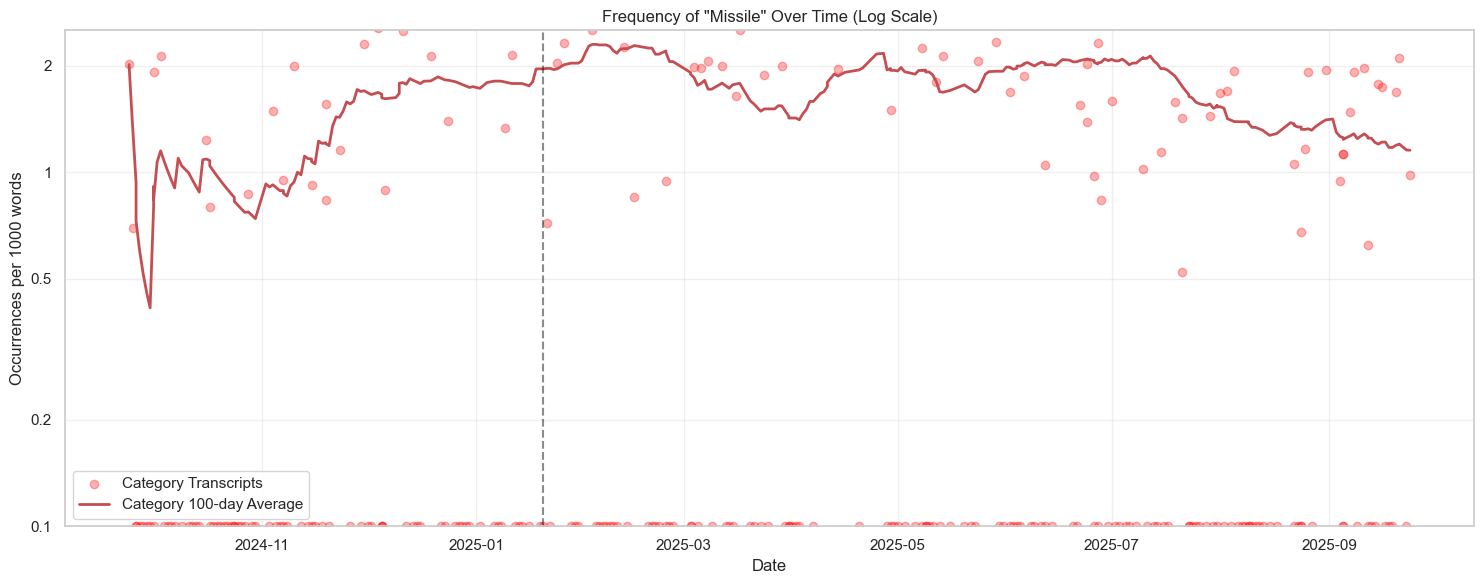

/Users/jstenger/Documents/repos/kalshi-research/src/phrase_analysis.py:211: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(np.log10(0.1), np.log10(ymax + 0.1))



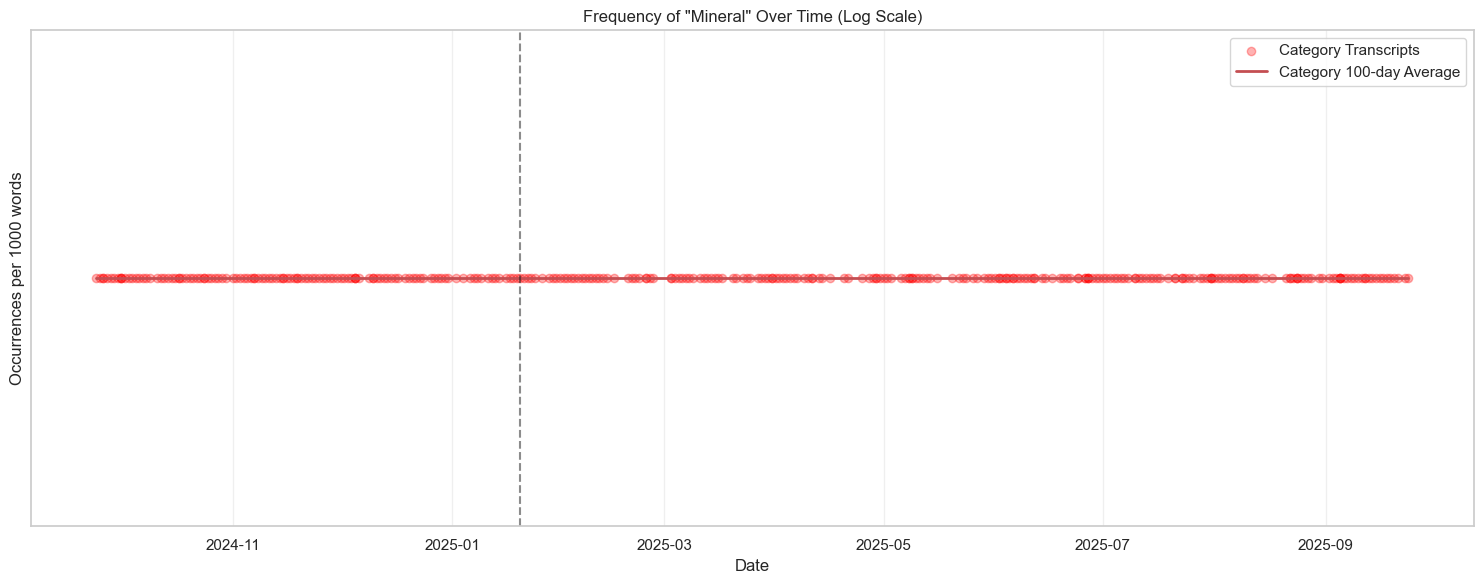


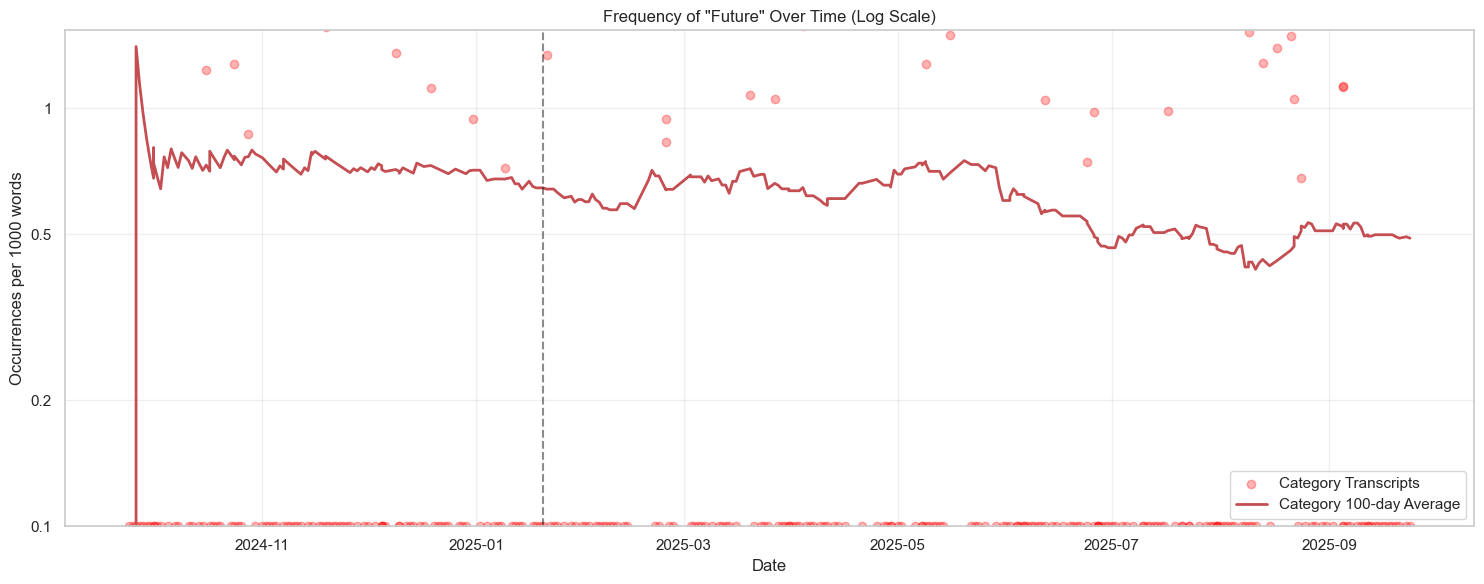


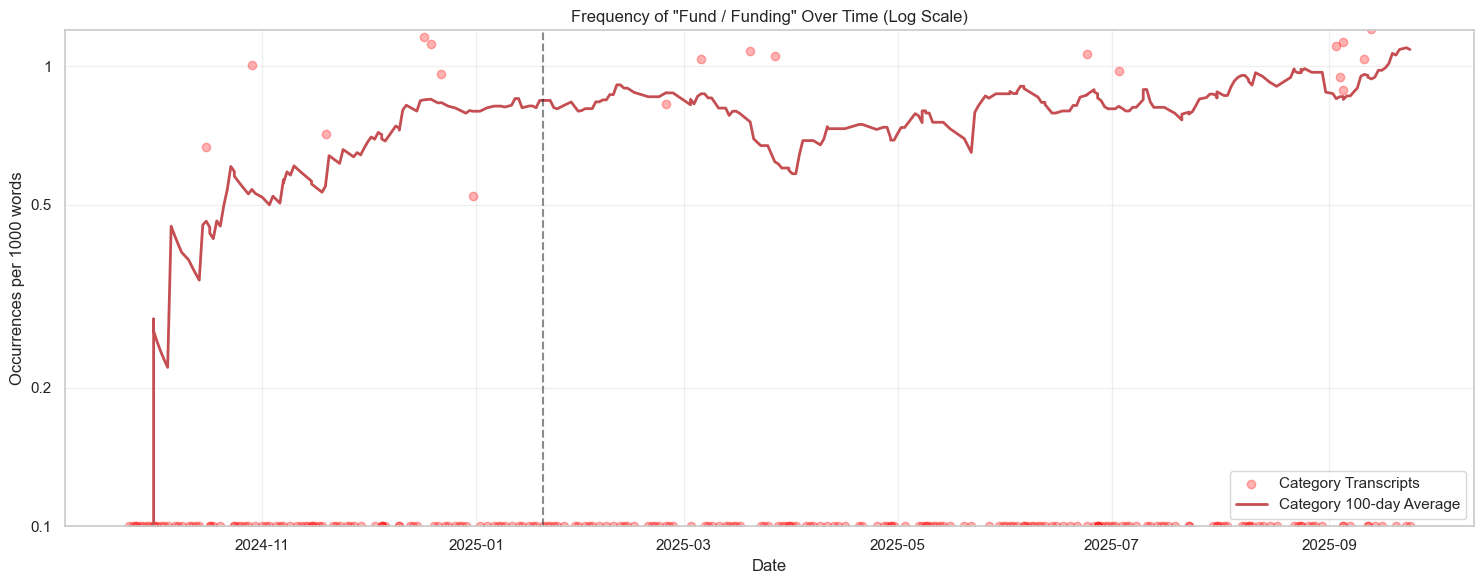


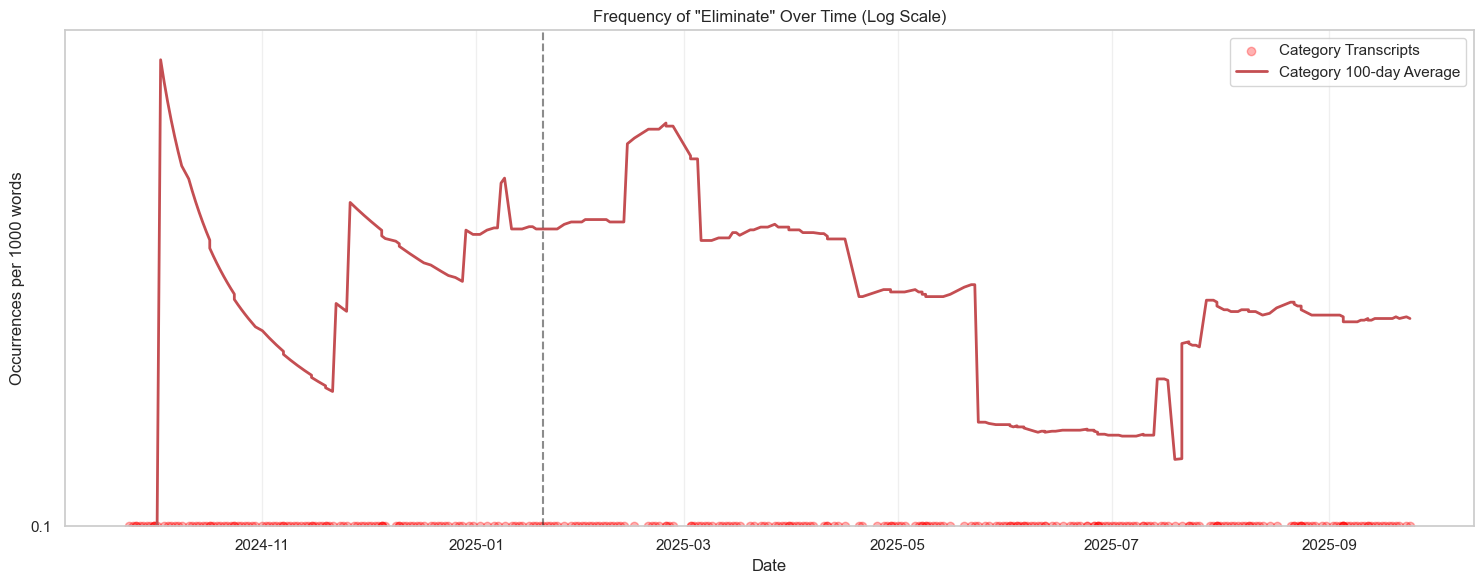


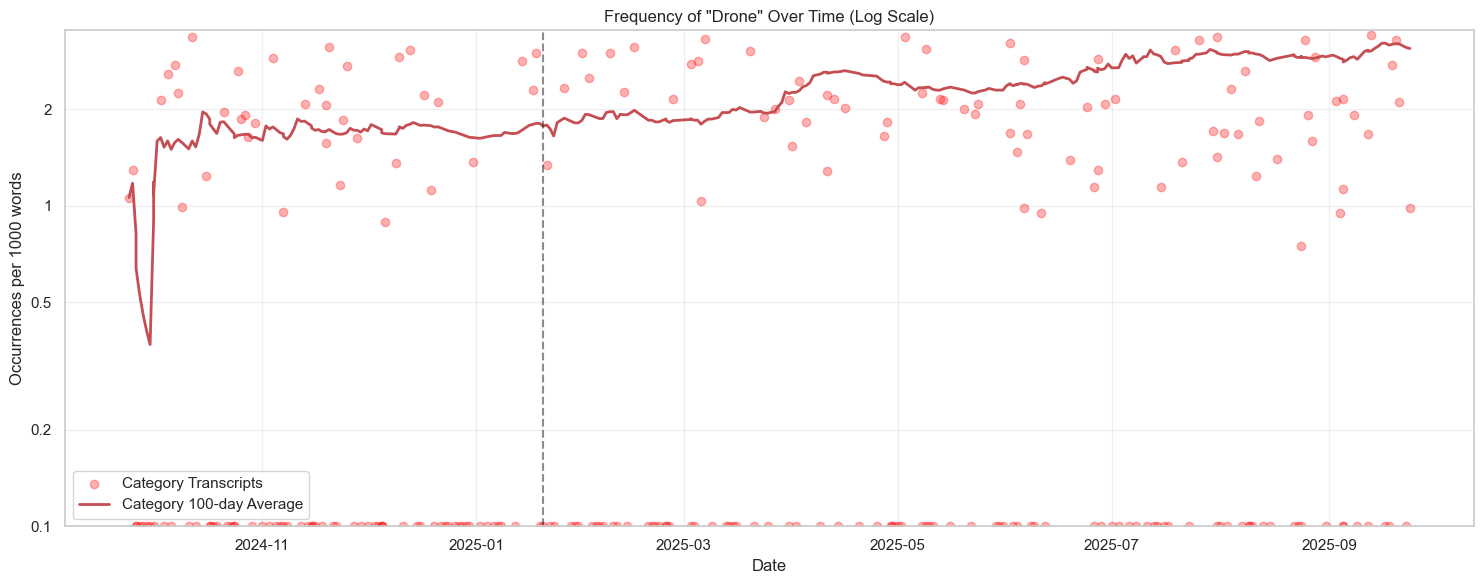


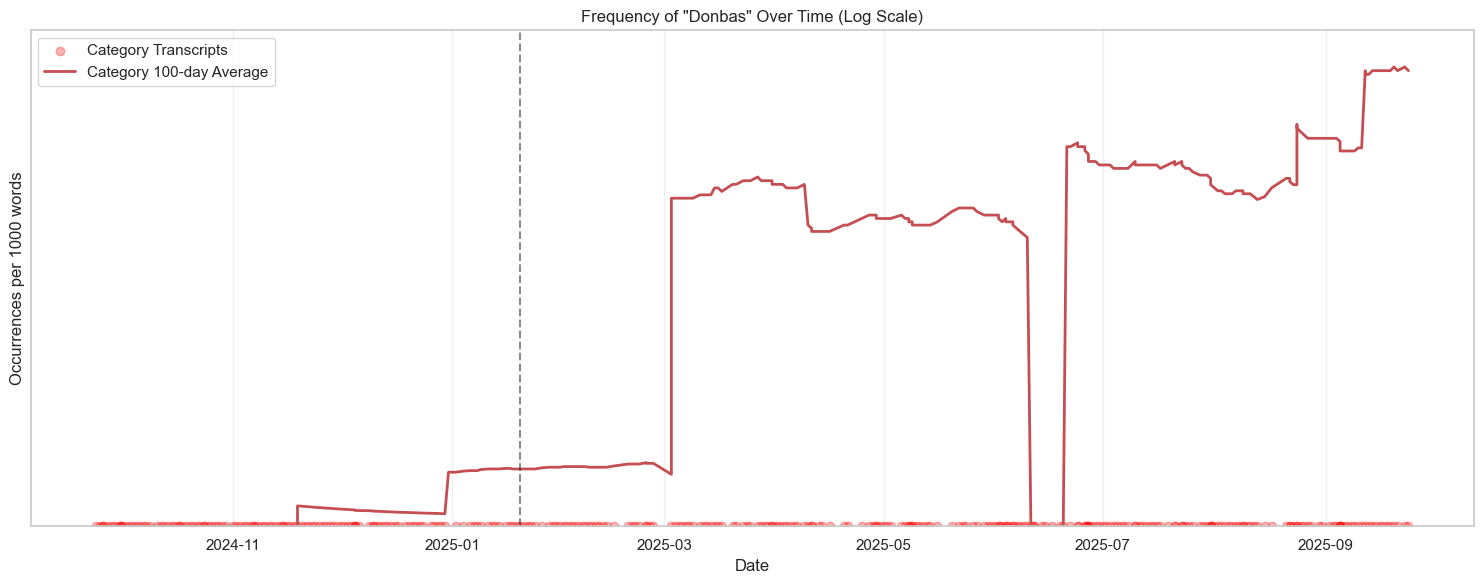

/Users/jstenger/Documents/repos/kalshi-research/src/phrase_analysis.py:211: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(np.log10(0.1), np.log10(ymax + 0.1))



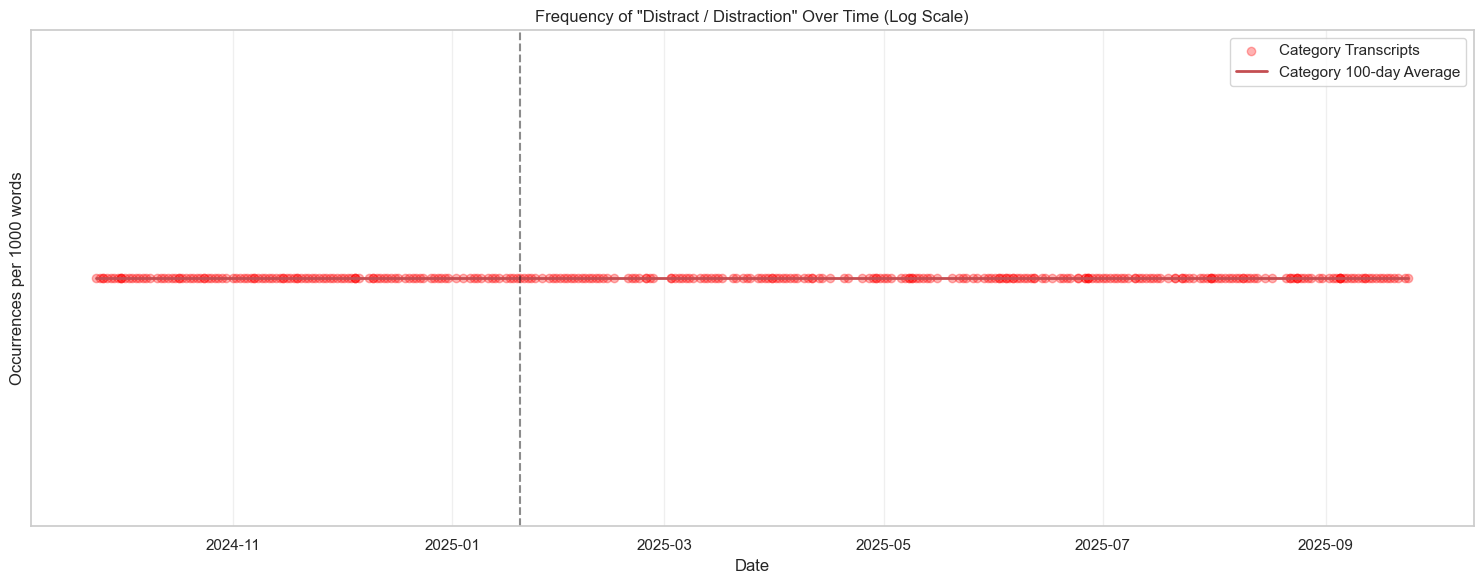


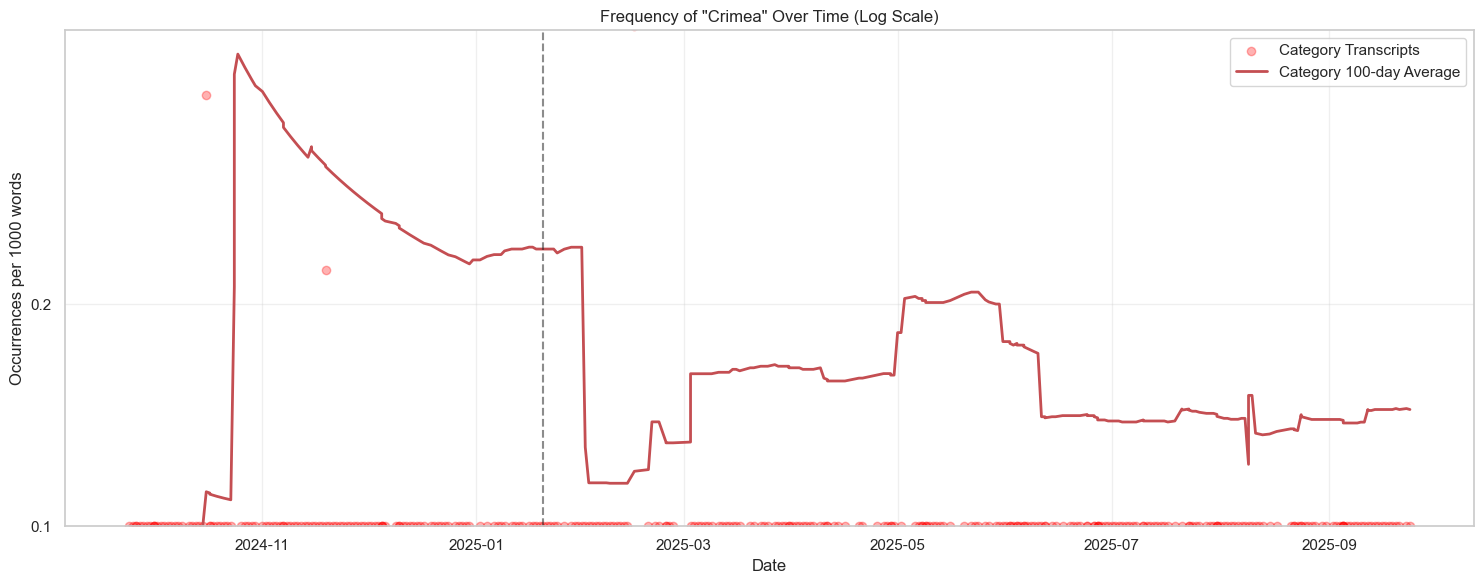


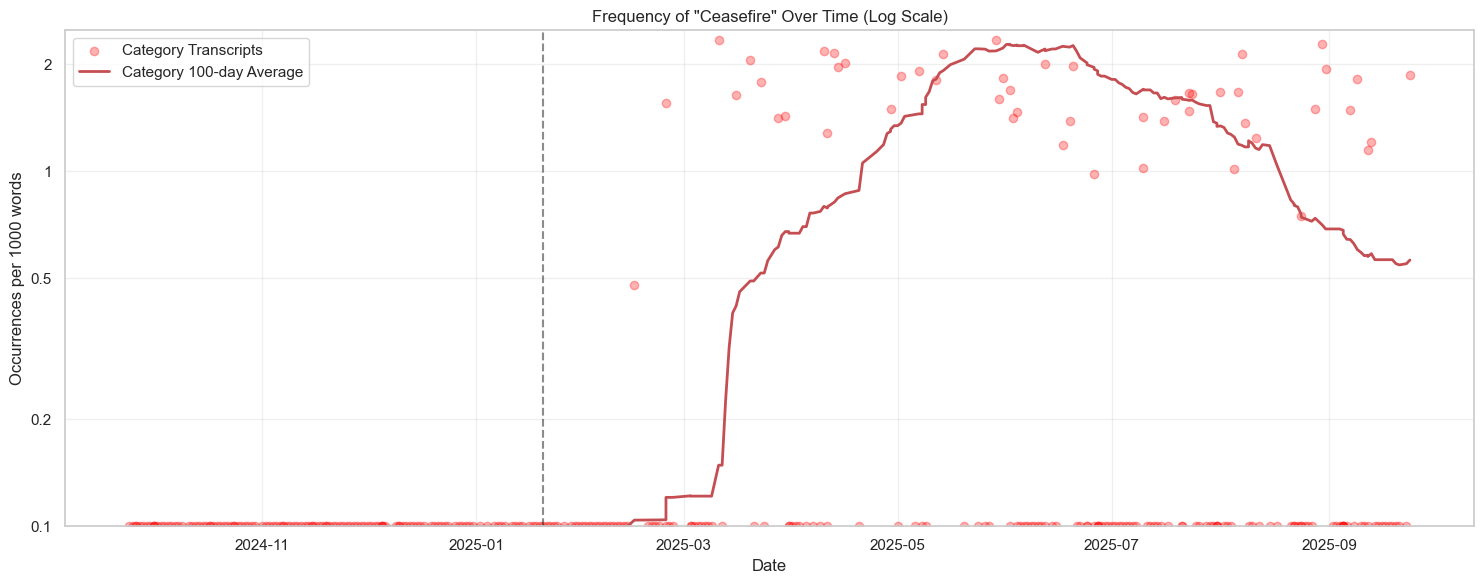

In [18]:
plot_phrase_frequency_over_time_all(df, phrases=SEARCH_PHRASES, log_scale=True, window=100)

In [27]:
analyze_files_phrase_occurrences(df[df['file'].str.contains('Security_Council|General_Assembly|United_Nations')], SEARCH_PHRASES)


Found 3 matching files:

  2024-09-24_Russias_War_Against_Ukraine_Will_End_Because_the_UN_Charter_Will_Work__Speech_by_the_President_of_Ukraine_at_the_High_Level_Meeting_of_the_UN_Security_Council.txt
  2024-09-25_There_Can_Be_No_Just_Peace_Without_Ukraine_Speech_of_the_President_at_the_UN_General_Assembly.txt
  2025-09-24_Address_by_the_President_at_the_High-Level_Meeting_of_the_UN_Security_Council_on_Ukraine.txt


Phrase occurrences across selected files (sorted by total occurrences):


/Users/jstenger/Documents/repos/kalshi-research/src/phrase_analysis.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phrase_rows['Total'] = phrase_rows.sum(axis=1)


,2024-09-24_Russias_War_Against_Ukraine_Will_End_Because_the_UN_Charter_Will_Work__Speech_by_the_President_of_Ukraine_at_the_High_Level_Meeting_of_the_UN_Security_Council.txt,2024-09-25_There_Can_Be_No_Just_Peace_Without_Ukraine_Speech_of_the_President_at_the_UN_General_Assembly.txt,2025-09-24_Address_by_the_President_at_the_High-Level_Meeting_of_the_UN_Security_Council_on_Ukraine.txt
Word Count,1042,1681,1130
Putin,6,8,5
Drone,1,2,1
Missile,2,1,1
Ceasefire,0,0,2
Unity,2,0,0
Trump,0,0,2
Truce,0,1,1
Soldier,0,2,0
Nobel,0,1,0



Summary:
Total files processed: 3
Total word count: 3,853


Expected length from category data: 702 words


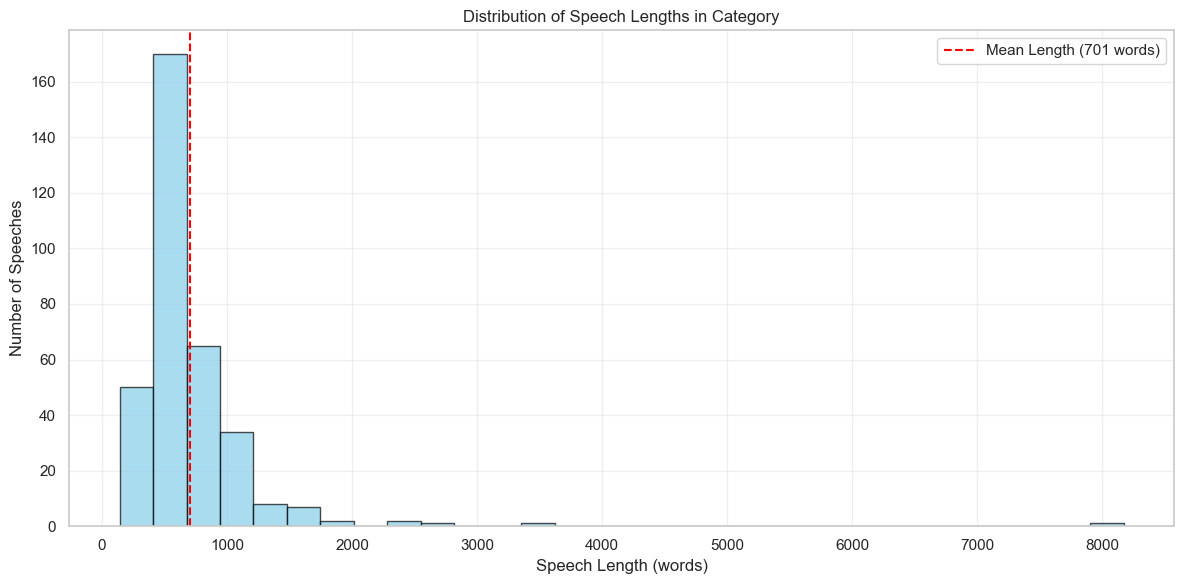

In [28]:
plot_length_distribution(df)

In [29]:
length = 1681

## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [40]:
# Calculate predictions from different data sources
print("using length: ", length)
predictions_all = calculate_poisson_predictions(df, length, SEARCH_PHRASES)

print("Predictions based on all appearances:")
display(format_prediction_table(predictions_all))

predictions_recent = calculate_poisson_predictions(df_recent, length, SEARCH_PHRASES)

print("Predictions based on recent appearances:")
display(format_prediction_table(predictions_recent))


using length:  1681
Predictions based on all appearances:


,Phrase,Expected,Historical Rate,Total Historical,P(≥1)
15,Drone,3.70,2.198,526,97.5%
6,Putin,2.43,1.446,346,91.2%
10,Missile,2.31,1.375,329,90.1%
13,Fund / Funding,1.21,0.719,172,70.1%
19,Ceasefire,1.02,0.606,145,63.9%
12,Future,0.98,0.581,139,62.3%
1,Unity,0.93,0.552,132,60.4%
3,Trump,0.82,0.485,116,55.7%
4,Soldier,0.62,0.368,88,46.1%
9,Mission,0.24,0.142,34,21.2%


Predictions based on recent appearances:


,Phrase,Expected,Historical Rate,Total Historical,P(≥1)
15,Drone,4.24,2.519,67,98.6%
6,Putin,3.92,2.331,62,98.0%
10,Missile,1.83,1.090,29,84.0%
13,Fund / Funding,1.83,1.090,29,84.0%
3,Trump,1.71,1.015,27,81.9%
19,Ceasefire,0.63,0.376,10,46.9%
12,Future,0.51,0.301,8,39.7%
9,Mission,0.19,0.113,3,17.3%
1,Unity,0.13,0.075,2,11.9%
16,Donbas,0.13,0.075,2,11.9%


## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

In [41]:
print("using length: ", length)

print("Negative Binomial Predictions based on all appearances:")
nb_predictions = calculate_negative_binomial_predictions(df, length, SEARCH_PHRASES)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on recent appearances:")
nb_predictions_recent = calculate_negative_binomial_predictions(df_recent, length, SEARCH_PHRASES)
display(format_prediction_table(nb_predictions_recent))


using length:  1681
Negative Binomial Predictions based on all appearances:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3)
15,Drone,3.70,0.60,26.41,69.3%,0.426
6,Putin,2.43,0.61,12.06,62.6%,0.324
10,Missile,2.31,0.35,17.75,50.6%,0.270
13,Fund / Funding,1.21,0.31,5.93,38.9%,0.160
19,Ceasefire,1.02,0.15,7.78,26.8%,0.122
12,Future,0.98,0.48,2.96,41.3%,0.130
1,Unity,0.93,0.23,4.69,31.0%,0.121
3,Trump,0.82,0.26,3.39,30.8%,0.107
4,Soldier,0.62,0.13,3.51,20.5%,0.078
9,Mission,0.24,0.10,0.86,11.5%,0.028


Negative Binomial Predictions based on recent appearances:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3)
15,Drone,4.24,1.09,20.75,82.2%,0.540
6,Putin,3.92,1.36,15.25,84.1%,0.542
10,Missile,1.83,1.40,4.23,69.0%,0.277
13,Fund / Funding,1.83,0.56,7.84,55.6%,0.253
3,Trump,1.71,0.70,5.84,58.0%,0.244
19,Ceasefire,0.63,0.51,1.42,33.6%,0.072
12,Future,0.51,0.38,1.18,27.5%,0.056
9,Mission,0.19,0.20,0.37,12.5%,0.015
1,Unity,0.13,0.10,0.35,7.8%,0.011
16,Donbas,0.13,100.00,0.10,11.9%,0.000


## Recent Usage in context

In [34]:
get_recent_contexts_all(df, SEARCH_PHRASES, n=10)


=== Recent usage of 'Unity' ===

Date: 2025-09-20 ()
Context: ...lear support of Ukraine, of our independence, of our sovereignty. Europe’s positions are growing stronger, and each year we enhance Europe’s capabilities. All of us, contributing together. Due to our unity, due to our joint projects. I thank every partner. This week has brought us closer to finalizing the 19th sanctions package against Russian aggression; we expect its approval soon. We will quickly syn...

Date: 2025-09-17 ()
Context: ...th Europe’s entire team and many European leaders, we have proven that Russia was completely mistaken in its attitude toward Europe and Europeans. And it is crucial that Ukraine only adds to Europe’s unity, strength, and influence in global affairs. Now we can see how relations between Europe and the United States are being reshaped, how Europe is building its new position in global affairs. It is vital...

Date: 2025-08-24 ()
Context: ...n, indeed, in a single day, gather and unite the

## Per-Speech Frequencies


In [46]:
get_per_appearance_frequency({'all': df, 'over 1000 words': df[df['text_length'] > 1000], 'recent': df_recent, 'recent over 1000 words': df_recent[df_recent['text_length'] > 1000]}, SEARCH_PHRASES)


Percentage of Appearances Containing Each Phrase:


,all,over 1000 words,recent,recent over 1000 words
Phrase,,,,
Drone,56.9%,69.6%,75.0%,66.7%
Missile,45.7%,71.7%,65.6%,66.7%
Putin,38.7%,67.4%,62.5%,66.7%
Fund / Funding,31.1%,50.0%,56.2%,50.0%
Future,25.5%,54.3%,18.8%,16.7%
Ceasefire,23.2%,26.1%,25.0%,33.3%
Trump,21.7%,32.6%,37.5%,66.7%
Unity,17.6%,45.7%,6.2%,0.0%
Soldier,16.7%,28.3%,0.0%,0.0%
